Building features for T-PA: 100%|██████████| 1411220/1411220 [18:33<00:00, 1267.28it/s]



=== Feature Importance ===
token_set      : 0.2565
jw             : 0.2496
lev_ratio      : 0.1874
jaccard        : 0.1080
soundex_eq     : 0.0851
len_diff       : 0.0581
prefix         : 0.0531
acronym        : 0.0022


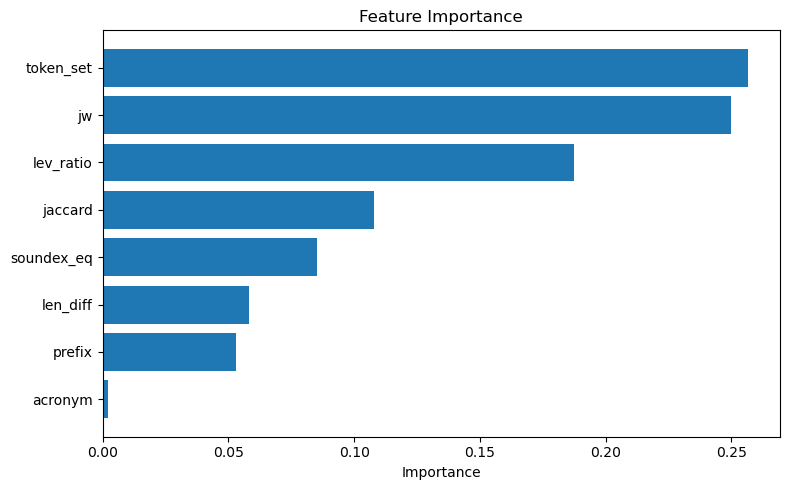


=== Validation Threshold Results ===
  Threshold    Precision    Recall     F1
-----------  -----------  --------  -----
        0.3        0.806     0.971  0.881
        0.4        0.843     0.959  0.897
        0.5        0.87      0.944  0.905
        0.6        0.898     0.922  0.91
        0.7        0.932     0.888  0.909
        0.8        0.963     0.842  0.899
        0.9        0.985     0.767  0.863

★ Best threshold (F1 on validation) = 0.65

=== Final Mapping Metrics ===
Precision 0.348  Recall 0.920  F1 0.505
Accuracy  0.974  ROC-AUC 0.992  PR-AUC 0.821

Top‑1 Accuracy  83.007%

Total runtime 5465.8s


In [6]:
# ---------- 1. 依赖与工具 ----------
import re, time, random, math, itertools
import pandas as pd
from unidecode import unidecode
from datasketch import MinHash, MinHashLSH
from joblib import Parallel, delayed
from rapidfuzz import fuzz, distance
import jellyfish
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (precision_recall_fscore_support, f1_score,
                             accuracy_score, confusion_matrix,
                             roc_auc_score, average_precision_score, classification_report)
# XGBoost（可选对比）
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

# ---------- 2. 数据读取 & 标准化 ----------
def read_df(path):
    return pd.read_csv(path)

def normalize(txt: str) -> str:
    txt = unidecode(txt or "").lower()
    txt = re.sub(r"[^a-z0-9\s]", " ", txt)
    return " ".join(txt.split())

def standardize(df, col):
    tqdm.pandas(desc=f"Normalize {col}")
    df["norm"] = df[col].progress_apply(normalize)
    return df

# ---------- 3. 阻塞通道 ----------
def minhash_2g(s):
    m = MinHash(num_perm=128)
    # 使用 2-gram 生成特征
    grams = [s[i:i+2] for i in range(len(s)-1)] or [s]
    for g in grams:
        m.update(g.encode())
    return m

def block_key_B(s):
    return f"{s[0]}_{len(s)//4}"

def block_key_C(s):
    return f"{jellyfish.soundex(s)}_{s[:3]}"

def add_blocks(df):
    tqdm.pandas(desc="Blocking keys")
    df["mh"]   = df["norm"].progress_apply(minhash_2g)
    df["keyB"] = df["norm"].apply(block_key_B)
    df["keyC"] = df["norm"].apply(block_key_C)
    return df

# ---------- 4. 候选对生成 (含 Top-N 限制) ----------
def lsh_build(df, tag, thr=0.65):
    lsh = MinHashLSH(threshold=thr, num_perm=128)
    for i, row in df.iterrows():
        lsh.insert(f"{tag}_{i}", row.mh)
    return lsh

def pairs_from_lsh(query, ref, lsh, tag):
    out = []
    for qi, q in tqdm(query.iterrows(), total=len(query), desc=f"L‑query {tag}"):
        for k in lsh.query(q.mh):
            ri = int(k.split('_')[1])
            out.append((qi, ri))
    return out

def pairs_from_key(query, ref, col, tag):
    grp = ref.groupby(col)
    out = []
    for qi, q in tqdm(query.iterrows(), total=len(query), desc=f"Key‑query {tag}:{col}"):
        if q[col] in grp.groups:
            for ri in grp.get_group(q[col]).index:
                out.append((qi, ri))
    return out

def build_feature_row(q, r):
    a, b = q.norm, r.norm
    tokA, tokB = set(a.split()), set(b.split())
    feat = dict(
        jw         = fuzz.WRatio(a, b) / 100,
        lev_ratio  = 1 - distance.Levenshtein.normalized_distance(a, b),
        token_set  = fuzz.token_set_ratio(a, b) / 100,
        prefix     = int(a[:4] == b[:4]),
        len_diff   = abs(len(a) - len(b)),
        soundex_eq = int(jellyfish.soundex(a) == jellyfish.soundex(b)),
        jaccard    = len(tokA & tokB) / len(tokA | tokB or {""}),
        acronym    = int(''.join(w[0] for w in b.split()) in a or ''.join(w[0] for w in a.split()) in b)
    )
    feat.update(id_left=q.ID, id_right=r.ID)
    return feat

def generate_pairs(query, ref, tag, top_n=100):
    # 通道 A: MinHash‑LSH
    lsh = lsh_build(ref, f"{tag}A")
    idx_A = pairs_from_lsh(query, ref, lsh, f"{tag}A")
    # 通道 B & C: 直接键匹配
    idx_B = pairs_from_key(query, ref, "keyB", f"{tag}B")
    idx_C = pairs_from_key(query, ref, "keyC", f"{tag}C")
    idx = set(idx_A) | set(idx_B) | set(idx_C)
    
    # 分组每个 query 并保留 Top-N 候选对（依据 WRatio 排序）
    grouped = {}
    for i, j in idx:
        grouped.setdefault(i, []).append(j)
    reduced_pairs = []
    for i, js in grouped.items():
        js_sorted = sorted(js, key=lambda j: fuzz.WRatio(query.loc[i].norm, ref.loc[j].norm), reverse=True)
        for j in js_sorted[:top_n]:
            reduced_pairs.append((i, j))
    
    feats = Parallel(n_jobs=-1)(
        delayed(build_feature_row)(query.loc[i], ref.loc[j]) for i, j in tqdm(reduced_pairs, desc=f"Building features for {tag}")
    )
    return pd.DataFrame(feats)

# ---------- 5. 标注 & 采样 ----------
def label(df): 
    df["Y"] = (df.id_left == df.id_right).astype(int)
    return df

def downsample(df, r=4):
    pos = df[df.Y == 1]
    neg = df[df.Y == 0].sample(min(len(df[df.Y == 0]), r * len(pos)), random_state=42)
    return pd.concat([pos, neg]).sample(frac=1, random_state=42).reset_index(drop=True)

# ---------- 6. 模型训练与调参 ----------
# RandomForest 版本：加入 max_depth=15
def train_rf(X, y):
    return RandomForestClassifier(n_estimators=400, class_weight='balanced_subsample',
                                  max_depth=15, n_jobs=-1, random_state=42).fit(X, y)

# XGBoost 版本（可对比）
def train_xgb(X, y):
    return XGBClassifier(n_estimators=400, max_depth=10, learning_rate=0.1,
                         scale_pos_weight=len(y[y==0]) / len(y[y==1]),
                         n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss').fit(X, y)

def find_thr(clf, Xv, yv):
    p = clf.predict_proba(Xv)[:, 1]
    grid = [i/100 for i in range(5, 96, 5)]
    return max(grid, key=lambda t: f1_score(yv, p >= t))

def show_feature_importance(clf, feature_names):
    importances = clf.feature_importances_
    sorted_idx = sorted(zip(importances, feature_names), reverse=True)
    print("\n=== Feature Importance ===")
    for imp, name in sorted_idx:
        print(f"{name:<15}: {imp:.4f}")
    # 可视化
    plt.figure(figsize=(8, 5))
    plt.barh([x[1] for x in sorted_idx[::-1]], [x[0] for x in sorted_idx[::-1]])
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

# ---------- 7. 主流程 ----------
start = time.time()

# 读取数据（全量）
P = add_blocks(standardize(read_df("primary.csv"), "NAME"))
A = add_blocks(standardize(read_df("alternate.csv"), "NAME"))
T = add_blocks(standardize(read_df("test_01.csv"), "VARIANT"))

# 去重任务：包括 P↔P, A↔A, P↔A（可进一步聚簇）
pairs_PP = label(generate_pairs(P, P, "P-P", top_n=100))
pairs_AA = label(generate_pairs(A, A, "A-A", top_n=100))
pairs_PA = label(generate_pairs(A, P, "A-P", top_n=100))
pairs_dedup = pd.concat([pairs_PP, pairs_AA, pairs_PA]).drop_duplicates()

# 映射任务：T → (P∪A)
PA = pd.concat([P, A]).reset_index(drop=True)
pairs_map = label(generate_pairs(T, PA, "T-PA", top_n=100))

# 采样、训练划分
train_df = downsample(pairs_dedup, 4)
X, y = train_df.drop(columns=["id_left", "id_right", "Y"]), train_df.Y
val_cut = int(0.2 * len(X))
Xv, yv = X.iloc[:val_cut], y.iloc[:val_cut]
Xt, yt = X.iloc[val_cut:], y.iloc[val_cut:]

# 选择 RandomForest 模型
clf = train_rf(Xt, yt)
# 如需对比 XGBoost，可使用：clf = train_xgb(Xt, yt)

# 输出特征重要性
show_feature_importance(clf, X.columns)

# 多阈值调参
thresholds = [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
results = []
p_val = clf.predict_proba(Xv)[:, 1]
for t in thresholds:
    pred_t = (p_val >= t).astype(int)
    p_val_res, r_val, f_val, _ = precision_recall_fscore_support(yv, pred_t, average='binary', zero_division=0)
    results.append([t, round(p_val_res, 3), round(r_val, 3), round(f_val, 3)])

print("\n=== Validation Threshold Results ===")
import tabulate
print(tabulate.tabulate(results, headers=["Threshold", "Precision", "Recall", "F1"]))

# 选择最佳阈值（这里用 f1 最大化的方式）
thr = find_thr(clf, Xv, yv)
print(f"\n★ Best threshold (F1 on validation) = {thr:.2f}")

# 测试在映射任务上
Xm, ym = pairs_map.drop(columns=["id_left", "id_right", "Y"]), pairs_map.Y
prob = clf.predict_proba(Xm)[:, 1]
ypred = (prob >= thr).astype(int)

p_map, r_map, f_map, _ = precision_recall_fscore_support(ym, ypred, average='binary', zero_division=0)
acc_map = accuracy_score(ym, ypred)
auc_map = roc_auc_score(ym, prob)
prauc_map = average_precision_score(ym, prob)

print("\n=== Final Mapping Metrics ===")
print(f"Precision {p_map:.3f}  Recall {r_map:.3f}  F1 {f_map:.3f}")
print(f"Accuracy  {acc_map:.3f}  ROC-AUC {auc_map:.3f}  PR-AUC {prauc_map:.3f}")

# Top‑1 精度：每个 test 名中取预测概率最高的候选对
pairs_map["prob"] = prob
top1 = pairs_map.sort_values("prob", ascending=False).groupby("id_right").head(1)
print(f"\nTop‑1 Accuracy  {top1.eval('Y==1').mean():.3%}")

print(f"\nTotal runtime {time.time()-start:.1f}s")


In [ ]:
from joblib import Parallel, delayed
from concurrent.futures import ProcessPoolExecutor
import pandas as pd
import re
import jellyfish
from unidecode import unidecode
from rapidfuzz import fuzz, distance
from datasketch import MinHash, MinHashLSH
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import precision_recall_fscore_support
from tqdm.notebook import tqdm  # 引入进度条库

# 处理名称的标准化方法：并行化加速
def normalize(name: str) -> str:
    name = unidecode(name)  # 去除音符符号
    name = name.lower()  # 转为小写
    name = re.sub(r"[^a-z0-9\s]", " ", name)  # 清理特殊字符
    name = " ".join(name.split())  # 合并多余的空格
    return name

# LSH (MinHash) 特征计算
def minhash_features(name):
    m = MinHash()
    for d in name.split():
        m.update(d.encode('utf8'))
    return m

# 阻塞操作 - 使用LSH
def generate_block_keys(df, use_lsh=False):
    if use_lsh:
        df['minhash'] = Parallel(n_jobs=-1)(delayed(minhash_features)(name) for name in tqdm(df['norm_name'], desc="Generating MinHash"))
        return df
    else:
        df["soundex_key"] = df["norm_name"].apply(lambda x: jellyfish.soundex(x))
        return df

# 计算相似度特征
def build_features(a, b):
    return {
        "jw": fuzz.WRatio(a, b, score_cutoff=0)/100,  # Jaro-Winkler 相似度
        "lev_ratio": 1 - distance.Levenshtein.normalized_distance(a, b),  # Levenshtein 相似度
        "token_set": fuzz.token_set_ratio(a, b)/100,  # Token Set Ratio
        "prefix_match": int(a[:4] == b[:4]),  # 前缀匹配
        "len_diff": abs(len(a) - len(b)),  # 长度差异
        "same_soundex": int(jellyfish.soundex(a) == jellyfish.soundex(b))  # Soundex匹配
    }

# 匹配条件函数，避免使用lambda
def match_condition(primary_row, alternate_row, use_lsh):
    if (use_lsh and primary_row['minhash'] == alternate_row['minhash']) or \
       (not use_lsh and primary_row['soundex_key'] == alternate_row['soundex_key']):
        return True
    return False

# 新的函数：将lambda替换为普通函数以解决Pickle问题
def process_candidate_row(row, alternate_df, use_lsh):
    return process_row(row, alternate_df, use_lsh)

# 向量化候选对提取：避免使用iterrows
def extract_candidates(primary_df, alternate_df, use_lsh=False):
    candidates = []
    primary_keys = primary_df['minhash'] if use_lsh else primary_df['soundex_key']
    alternate_keys = alternate_df['minhash'] if use_lsh else alternate_df['soundex_key']
    
    # 向量化处理：避免双重循环
    primary_matches = primary_df[primary_df['minhash'].isin(alternate_keys)] if use_lsh else \
                      primary_df[primary_df['soundex_key'].isin(alternate_keys)]
    
    # 使用并行化计算相似度特征
    with ProcessPoolExecutor() as executor:
        results = list(executor.map(process_candidate_row, primary_matches.iterrows(), [alternate_df] * len(primary_matches), [use_lsh] * len(primary_matches)))
        candidates.extend([result for result in results if result is not None])

    return pd.DataFrame(candidates)

# 读取前1000条记录
def read_first_n_rows(file_path, n=1000):
    return pd.read_csv(file_path).head(n)

# 处理每一对候选行并计算特征
def process_row(row, alternate_df, use_lsh):
    primary_index, primary_row = row

    # 抽取匹配的候选记录
    candidates = []
    for _, alternate_row in alternate_df.iterrows():
        if match_condition(primary_row, alternate_row, use_lsh):
            features = build_features(primary_row['norm_name'], alternate_row['norm_name'])
            features['id_left'] = primary_row['id_left']
            features['id_right'] = alternate_row['id_right']
            candidates.append(features)

    return candidates

# 主程序
primary_df = read_first_n_rows('primary.csv', n=1000)  # 读取前1000条数据
alternate_df = read_first_n_rows('alternate.csv', n=1000)  # 读取前1000条数据
test_df = read_first_n_rows('test_01.csv', n=1000)  # 读取前1000条数据

# 标准化数据：并行化处理
primary_df['norm_name'] = Parallel(n_jobs=-1)(delayed(normalize)(name) for name in tqdm(primary_df['NAME'], desc="Standardizing Primary Names"))
alternate_df['norm_name'] = Parallel(n_jobs=-1)(delayed(normalize)(name) for name in tqdm(alternate_df['NAME'], desc="Standardizing Alternate Names"))

# 生成阻塞键
use_lsh = True  # 使用 LSH 阻塞
primary_df = generate_block_keys(primary_df, use_lsh=use_lsh)
alternate_df = generate_block_keys(alternate_df, use_lsh=use_lsh)

# 抽取候选对并构建特征，利用并行化加速
candidates_df = extract_candidates(primary_df, alternate_df, use_lsh=use_lsh)
print(candidates_df.head())

# 读取标注数据
labeled_df = pd.read_csv('labeled_candidates.csv').head(1000)  # 限制为前1000条记录

# 特征与标签
X = labeled_df.drop(columns=['id_left', 'id_right', 'name_left', 'name_right', 'Y/N'])
y = labeled_df['Y/N'].map({'Y': 1, 'N': 0})  # 转化为 1/0 标签

In [ ]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 随机森林模型
rf_model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1)  # 使用所有核
rf_model.fit(X_train, y_train)

# 评估：使用3折交叉验证，减少折数以加速训练
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
cv_score = cross_val_score(rf_model, X, y, cv=cv, scoring='accuracy').mean()
print(f"Cross-Validation Accuracy with 3 folds: {cv_score:.3f}")

# 计算模型在测试集上的表现
y_pred_rf = rf_model.predict(X_test)
precision_rf, recall_rf, f1_rf, _ = precision_recall_fscore_support(y_test, y_pred_rf, average='binary')

print(f"Random Forest Precision: {precision_rf:.3f}, Recall: {recall_rf:.3f}, F1-Score: {f1_rf:.3f}")

# 朴素贝叶斯模型
nb_model = BernoulliNB()
nb_model.fit(X_train, y_train)

# 评估贝叶斯模型
y_pred_nb = nb_model.predict(X_test)
precision_nb, recall_nb, f1_nb, _ = precision_recall_fscore_support(y_test, y_pred_nb, average='binary')

print(f"Naive Bayes Precision: {precision_nb:.3f}, Recall: {recall_nb:.3f}, F1-Score: {f1_nb:.3f}")


### 2. 数据预处理

在这一部分，我们对数据进行标准化处理：
- 将所有的名字转为小写字母
- 去除名字中的音符符号（如重音）
- 清理特殊字符，只保留字母、数字和空格
- 合并多余的空格

这一步确保我们对数据进行统一标准化，以便后续匹配。

### 3. LSH (MinHash) 特征计算

通过计算每个名称的 MinHash 特征来准备阻塞步骤。MinHash 是一种用于**局部敏感哈希 (LSH)** 的技术，可以通过比较小的指纹来加速相似性比较。


### 4. 阻塞技术：使用 LSH 或 Soundex

我们在这里实现了两种阻塞方法：
1. **LSH**（局部敏感哈希）：我们通过 MinHash 计算每个名称的指纹，并使用 LSH 来加速记录匹配。
2. **Soundex**：基于名称的 Soundex 码进行阻塞，适用于拼写变体较小的情况。

可以通过设置 `use_lsh` 为 `True` 或 `False` 来选择不同的阻塞方法。


### 5. LSH 阻塞实现

我们通过 LSH 将相似的记录分到相同的块中。这样，我们只需比较属于同一块的记录，避免了计算每个记录对的所有可能组合。


### 6. 提取候选对的相似度特征

我们使用多种方法计算记录对之间的相似度，如 **Jaro-Winkler 相似度**、**Levenshtein 距离** 和 **Token Set Ratio**。这些特征将在后续的分类模型中作为输入。


### 7. 抽取候选对

我们从 `primary_df` 和 `alternate_df` 中抽取候选对。如果两个记录属于同一块（通过阻塞键判断），我们将计算它们之间的相似度特征。


### 8. 读取数据

在这一部分，我们加载了 `primary.csv` 和 `alternate.csv` 数据，并进行标准化处理。同时，我们加载 `test_01.csv` 数据，准备进行映射任务。


### 9. 训练模型：随机森林和朴素贝叶斯

我们使用 **随机森林（RandomForestClassifier）** 和 **朴素贝叶斯（Naive Bayes）** 来对记录匹配进行分类。我们评估了两个模型的 **Precision**、**Recall** 和 **F1-Score**，以比较它们的表现。


### 10. 预测结果输出

在此部分，我们输出了每个测试样本的预测结果以及相应的概率。最终结果被保存到 `predictions_with_proba.csv` 文件中，供后续分析使用。
